In [ ]:
import pandas as pd
import geopandas as gpd
import geobr
import descartes
import matplotlib.pyplot as plt
import zipfile
import os
from matplotlib import style
from matplotlib.ticker import StrMethodFormatter
style.use("seaborn-v0_8-pastel")

In [ ]:
# Configurações do Pandas
pd.options.display.max_columns = 26

In [ ]:
# Arrays e dicionários úteis

columns = ["NU_ANO","TP_NACIONALIDADE","TP_SEXO","TP_FAIXA_ETARIA","TP_COR_RACA","TP_ESTADO_CIVIL",
           "TP_ST_CONCLUSAO","TP_ESCOLA","IN_TREINEIRO","NO_MUNICIPIO_ESC","SG_UF_PROVA","TP_PRESENCA_CN",
           "TP_PRESENCA_CH","TP_PRESENCA_LC","TP_PRESENCA_MT","NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC",
           "NU_NOTA_MT","TP_STATUS_REDACAO","NU_NOTA_COMP1","NU_NOTA_COMP2","NU_NOTA_COMP3","NU_NOTA_COMP4",
           "NU_NOTA_COMP5","NU_NOTA_REDACAO"]

renamed_columns = ["Ano","Nacionalidade","Sexo","Idade","Cor","Estado_civil","Situacao_EM","Tipo_Escola",
                   "Treineiro","Municipio","Estado","Presenca_CN","Presenca_CH","Presenca_LC","Presenca_MT",
                   "Ciencias_Natureza","Ciencias_Humanas","Linguagens_Codigos","Matematica","Status_Redacao",
                   "Ortografia","Desenvolvimento","Informacoes","Organizacao","Proposta","Redacao"]

# Conseguindo a relação das categorias das colunas
faixa_etaria = {
    1: "Menor de 17 anos",
    2: "17 anos",
    3: "18 anos",
    4: "19 anos",
    5: "20 anos",
    6: "21 anos",
    7: "22 anos",
    8: "23 anos",
    9: "24 anos",
    10: "25 anos",
    11: "Entre 26 e 30 anos",
    12: "Entre 31 e 35 anos",
    13: "Entre 36 e 40 anos",
    14: "Entre 41 e 45 anos",
    15: "Entre 46 e 50 anos",
    16: "Entre 51 e 55 anos",
    17: "Entre 56 e 60 anos",
    18: "Entre 61 e 65 anos",
    19: "Entre 66 e 70 anos",
    20: "Maior de 70 anos"
}

estado_civil = {
    0: "Não informado",
    1: "Solteiro(a)",
    2: "Casado(a)/Mora com companheiro(a)",
    3: "Divorciado(a)/Desquitado(a)/Separado(a)",
    4: "Viúvo(a)"
}

etnia = {
    0: "Não declarado",
    1: "Branca",
    2: "Preta",
    3: "Parda",
    4: "Amarela",
    5: "Indígena",
    6: "Não dispõe da informação"
}

nacionalidade = {
    0: "Não informado",
    1: "Brasileiro(a)",
    2: "Brasileiro(a) Naturalizado(a)",
    3: "Estrangeiro(a)",
    4: "Brasileiro(a) Nato(a), nascido(a) no exterior"
}

situacao_ensino_medio = {
    1: "Já concluí o Ensino Médio",
    2: "Estou cursando e concluirei o Ensino Médio em 2022",
    3: "Estou cursando e concluirei o Ensino Médio após 2022",
    4: "Não concluí e não estou cursando o Ensino Médio"
}

tipo_instituicao = {
    1: "Não Respondeu",
    2: "Pública",
    3: "Privada"
}

treineiro = {
    1: "Sim",
    0: "Não"
}

situacao_redacao = {
    1: "Sem problemas",
    2: "Anulada",
    3: "Cópia Texto Motivador",
    4: "Em Branco",
    6: "Fuga ao tema",
    7: "Não atendimento ao tipo textual",
    8: "Texto insuficiente",
    9: "Parte desconectada"
}

In [ ]:
# Pegar o arquivo .csv dos microdados de dentro de todos os zips
zip_data = {
    "Zip Files":[],
    "Folder Data":  os.listdir("information")
}

for zippedArch in zip_data["Folder Data"]:
    with zipfile.ZipFile(f"information\{zippedArch}") as zippedData:
        for file in zippedData.namelist():
            if "microdados" in file.lower() and file.endswith(".csv"):
                zip_data["Zip Files"].append(file)

In [ ]:
# Lambda pra ordenar os arquivos do mais antigo para o mais novo 2015 - 2022
zip_data["Zip Files"].sort(key = lambda x: x[22:-4])
zip_data["Folder Data"].sort(key = lambda x: x[16:-4])

In [ ]:
enem_collection = []

# Criando o megadataframe filtrado
for i in range(len(zip_data["Zip Files"])):
    with zipfile.ZipFile(f"information\{zip_data['Folder Data'][i]}") as microdata:
        with microdata.open(zip_data["Zip Files"][i]) as csv:
            
            data = pd.read_csv(csv,encoding="ISO-8859-1",sep=";",usecols=columns)
            # Renomeando as colunas
            data.columns = renamed_columns
            # Removendo as linhas onde não temos notas
            data.dropna(subset=["Ciencias_Natureza",'Ciencias_Humanas',"Ciencias_Humanas","Matematica","Redacao"],inplace=True)
            data.reset_index(inplace=True,drop=True)
            # Adicionando no array pra criar o Dataframe completo posteriormente
            enem_collection.append(data)


In [ ]:
enem = pd.concat(enem_collection)

In [ ]:
# Calculando a Nota Total de cada pessoa
enem['Nota Total'] = enem[['Ciencias_Natureza','Ciencias_Humanas','Matematica','Linguagens_Codigos','Redacao']].sum(axis=1)/5

In [ ]:
enem.groupby("Ano")[["Ciencias_Humanas","Linguagens_Codigos","Matematica","Redacao"]].mean()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))

axs[0,0].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Redacao"].mean())
axs[0,0].set_title("Média Redação",fontsize=15,color='gray',loc='left')
axs[0,0].set_ylabel("Média Redação",fontsize=15,color='gray',loc='top')

axs[1,0].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Ciencias_Humanas"].mean())
axs[1,0].set_title("Média Ciências Humanas",fontsize=15,color='gray',loc='left')
axs[1,0].set_ylabel("Média Ciências Humanas",fontsize=15,color='gray',loc='top')

axs[0,1].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Matematica"].mean())
axs[0,1].set_title("Média Matemática",fontsize=15,color='gray',loc='left')
axs[0,1].set_ylabel("Média Matemática",fontsize=15,color='gray',loc='top')

axs[1,1].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Linguagens_Codigos"].mean())
axs[1,1].set_title("Média Linguagens",fontsize=15,color='gray',loc='left')
axs[1,1].set_ylabel("Média Linguagens",fontsize=15,color='gray',loc='top')


fig.suptitle('Média de desempenho do ENEM',fontsize=27,color="#393E41")

plt.savefig('foo.png', bbox_inches='tight')

## Qual o Ano que tivemos mais Treineiros?

In [ ]:
# Buscando o percentual de Treineiros em cada ano
trein_year = pd.DataFrame(enem.groupby("Ano")['Treineiro'].value_counts(normalize=True)).reset_index()

In [ ]:
# Pivotando a e ajustando a tabela pra ficar mais fácil de usar um gráfico horizontal
trein_year = trein_year.pivot_table('proportion', ['Ano'], 'Treineiro').reset_index()
trein_year.columns = ['Ano',"Não Treineiros","Treineiros"]
trein_year = trein_year[['Ano',"Treineiros","Não Treineiros"]].sort_values("Treineiros",ascending=False)
# Transformando os resultados em Porcentagem pra poder utilizar no gráfico a seguir
trein_year = trein_year.map(lambda x: x*100 if type(x) == float else x)

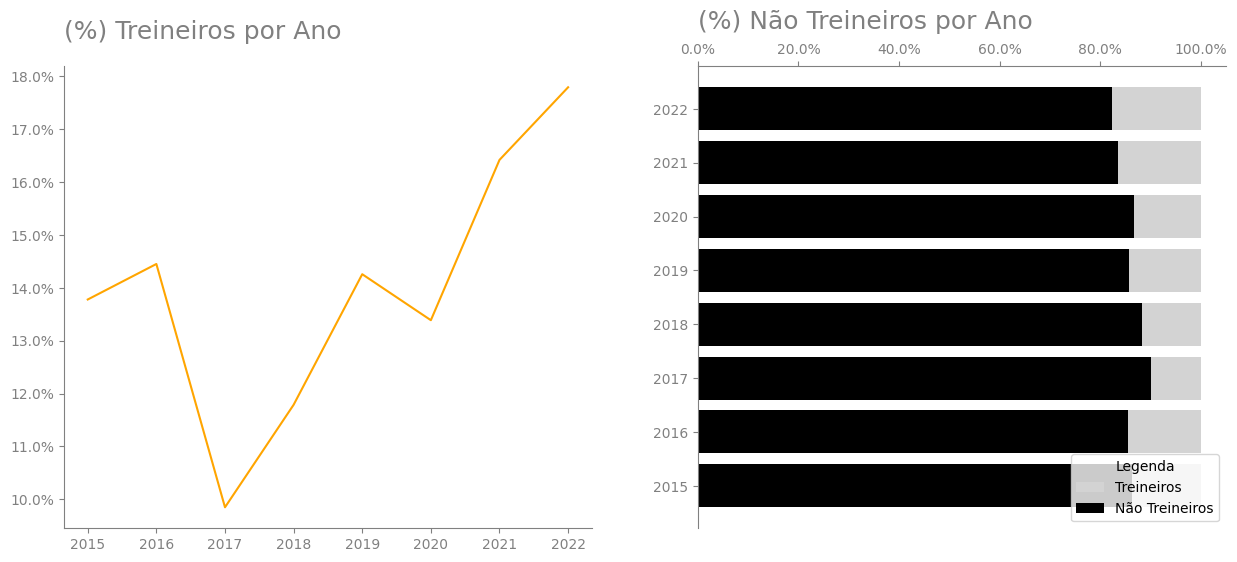

In [225]:
# Criando os gráficos Line Chart e Horizontal Bar
fig, axs = plt.subplots(1,2,figsize=(15,6))

# Criando o Line Chart pra visualizar o crescimento de Treineiros ao longo dos anos
axs[0].plot(trein_year['Ano'],trein_year['Treineiros'],color='orange')
axs[0].yaxis.set_major_formatter(StrMethodFormatter('{x}%'))
axs[0].set_title("(%) Treineiros por Ano",loc='left',color='gray',pad=20,size=18)
# Removendo as bordas do gráfico
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_color("gray")
axs[0].spines['left'].set_color("gray")
axs[0].tick_params(axis='x', colors='gray')
axs[0].tick_params(axis='y', colors='gray')

# Criando o Horizontal Bar
b1 = plt.barh(trein_year['Ano'],trein_year["Não Treineiros"],color='black')
b2 = plt.barh(trein_year['Ano'],trein_year["Treineiros"],color='lightgray',left=trein_year["Não Treineiros"])

plt.title("(%) Não Treineiros por Ano",loc='left',color='gray',pad=10,size=18)
plt.legend([b2, b1], ["Treineiros", "Não Treineiros"], title="Legenda", loc="lower right")

# Configurando os Axis do gráfico pra obter uma visualização mais Limpa e Uniforme dos dados
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x}%'))
plt.gca().xaxis.set_ticks_position('top')
plt.tick_params(axis='x', colors='gray')
plt.tick_params(axis='y', colors='gray')
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_color("gray")
plt.gca().spines['left'].set_color("gray")

## Quais os Estados com as melhores notas?

In [233]:
# Conseguindo os dados de cada estado
brazil_grades = pd.DataFrame(enem.groupby('Estado')['Nota Total'].sum()).reset_index()

In [234]:
# Criando o mapa do Brasil com geobr e descartes
brazil = geobr.read_country(year=2020)

In [235]:
# Conseguindo os valores geográficos de cada estado para relacionar com os valores obtidos dos microdados
brazil_grades = brazil.merge(brazil_grades[["Nota Total","Estado"]],left_on="abbrev_state",right_on="Estado").drop("Estado",axis=1).sort_values("Nota Total",ascending=False)

In [237]:
brazil_grades.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry,Nota Total
19,35.0,SP,São Paulo,3.0,Sudeste,"MULTIPOLYGON (((-51.96222 -21.49331, -51.95525...",2.633591e+09
16,31.0,MG,Minas Gerais,3.0,Sudeste,"MULTIPOLYGON (((-50.74037 -19.21316, -50.74083...",1.741638e+09
15,29.0,BA,Bahia,2.0,Nordeste,"MULTIPOLYGON (((-46.19827 -12.50407, -46.20533...",1.171576e+09
18,33.0,RJ,Rio De Janeiro,3.0,Sudeste,"MULTIPOLYGON (((-44.16561 -22.67345, -44.17145...",1.108864e+09
9,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-41.18292 -4.01797, -41.18862 ...",9.503246e+08


c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:386: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  data[:] = [getattr(geom, op, None) for geom in left.data]
c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
 

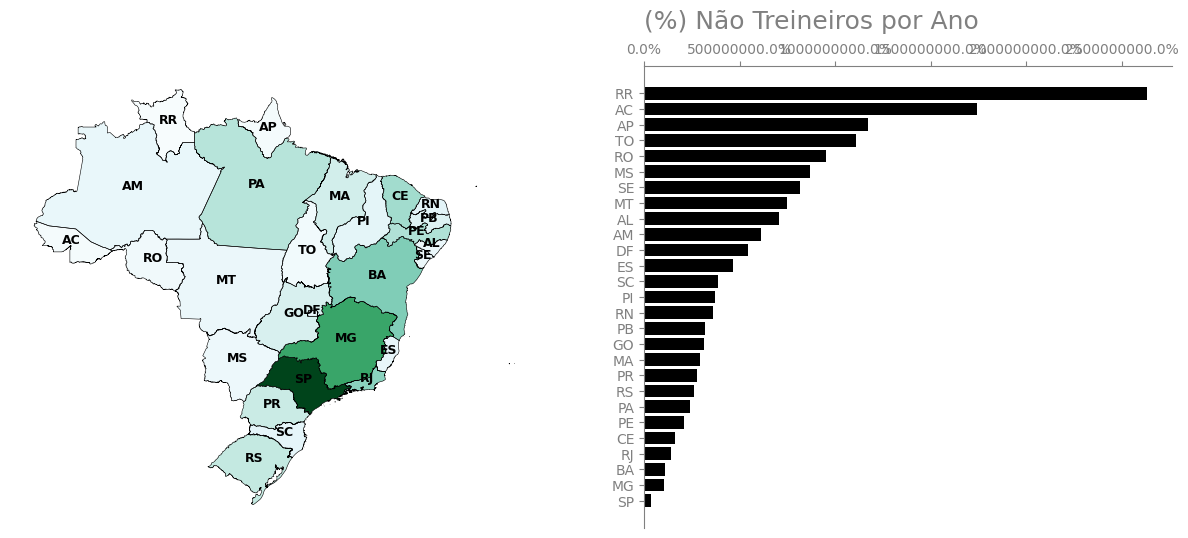

In [244]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

# Criando o Heatmap Geográfico baseado no valor das notas do Enem por Estado

# Removendo o frame em volta do mapa pra melhorar a visualização
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])

# Lambda pra adicionar a sigla dos estados no mapa e facilitar a identificação
brazil_grades.apply(lambda x: axs[0].annotate(text=x['abbrev_state'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=9, weight='bold'),axis=1)

brazil_grades.boundary.plot(ax=axs[0], color='Black', linewidth=.4)
brazil_grades.plot(column="Nota Total",ax=axs[0], cmap='BuGn')


# Criando um Horizontal Chart pra visualizarem melhor a relação dos Estados
b1 = plt.barh(brazil_grades['abbrev_state'],sorted(brazil_grades["Nota Total"]),color='black')

plt.title("(%) Não Treineiros por Ano",loc='left',color='gray',pad=10,size=18)

# Configurando os Axis do gráfico pra obter uma visualização mais Limpa e Uniforme dos dados
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x}%'))
plt.gca().xaxis.set_ticks_position('top')
plt.tick_params(axis='x', colors='gray')
plt.tick_params(axis='y', colors='gray')
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_color("gray")
plt.gca().spines['left'].set_color("gray")


c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:386: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  data[:] = [getattr(geom, op, None) for geom in left.data]
c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
 

<Axes: >

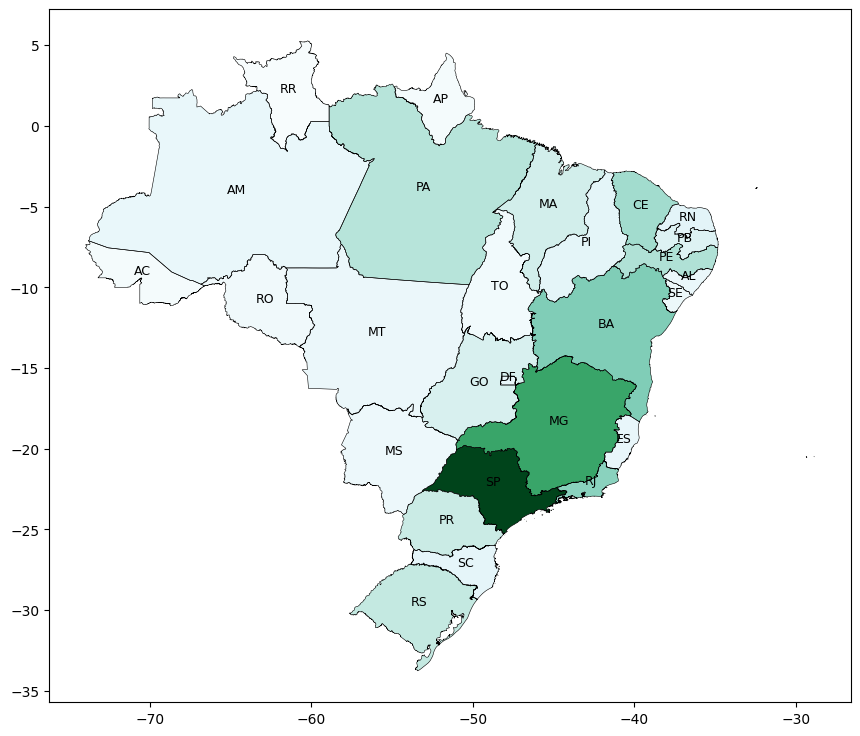

In [220]:
fig = plt.figure(1, figsize=(15,9)) 
ax = fig.add_subplot()
brazil_grades.apply(lambda x: ax.annotate(text=x['abbrev_state'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=9),axis=1);
brazil_grades.boundary.plot(ax=ax, color='Black', linewidth=.4)
brazil_grades.plot(column="Nota Total",ax=ax, cmap='BuGn', figsize=(12, 12))